# LSTM

In this notebook, we will go through basics of LSTM on IMDB dataset. 

Here we will use [fastai](https://github.com/fastai/course-v3  "Fastai Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/lstm/gru/nlp/2019/01/28/Force-of-LSTM-and-GRU/). This is notebook which replicates the result of blog and runs in colab. Enjoy!

Let's see at [nlpprogess](http://nlpprogress.com/english/sentiment_analysis.html) what is the current state-of-the-art in sentiment analysis.


Model | Accuracy | Paper |
----- | -------- | ------|
ULMFit| 95.4     | [Universal Language Model Fine-tuning for Text Classification](https://arxiv.org/abs/1801.06146)|
Block-sparse LSTM| 94.99 | [GPU Kernels for Block-Sparse Weights](https://s3-us-west-2.amazonaws.com/openai-assets/blocksparse/blocksparsepaper.pdf)|
oh-LSTM | 94.1 | [Supervised and Semi-Supervised Text Categorization using LSTM for Region Embeddings](https://arxiv.org/abs/1602.02373) |
Virtual adversarial training  | 94.1 | [Adversarial Training Methods for Semi-Supervised Text Classification](https://arxiv.org/abs/1605.07725) |
BCN+Char+CoVe | 91.8 | [Learned in Translation: Contextualized Word Vectors](https://arxiv.org/abs/1708.00107) |


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/lstm_and_gru/lstm_and_gru_fastai.ipynb)

## IMDB data

Code Adapted from: [link](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb)

In [0]:
from fastai.text import *

Preparing the data

First let's download the dataset we are going to study. The dataset has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We will use sample and show different steps involved in converting text data usable for classifier

In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [0]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

## Method 1: Text DataBunch

In [0]:
# create text databunch

data_lm = TextDataBunch.from_csv(path, 'texts.csv')

 A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

In [0]:
# # save databunch
# data_lm.save()

In [0]:
# # load the saved databunch instead of runnning all steps above
# data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

*    we need to take care of punctuation
*   some words are contractions of two different words, like isn't (is n't) or don't (do n't)
*   we may need to clean some parts of our texts, if there's HTML code for instance


To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.


In [0]:
data = TextClasDataBunch.from_csv(path, 'texts.csv')
data.show_batch()

text,target
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the sweetest and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese surfaces but underneath the surfaces it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative




The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols:

  * the "'s" are grouped together in one token
  * the contractions are separated like this: "did", "n't"
  * content has been cleaned for any HTML symbol and lower cased
  * there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).




### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correspondance from ids to tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).


In [0]:
# mapping from int to string
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',']

In [0]:
# sample training example 
# tokenization
data.train_ds[0][0]

In [0]:
# numericalization
data.train_ds[0][0].data[:10]

array([   2,    4,   13,    8,  287, 4651,   49,    4, 6033,    4])

We will combine both steps i.e creating databunch and tokenization and numericalization

We will use the complete dataset to train our classifier

In [0]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm')]

In [0]:
#batch size
bs = 32

# datablock for language model
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))

In [0]:
data_lm.show_batch()

idx,text
0,"great fighting and a lot of the locations were beautifully shot , great effects , and a lot of sword play . xxmaj another solid effort by xxmaj tadanobu xxmaj asano in my opinion . xxmaj well i really ca n't say anymore about the movie , but if you 're only outlook on xxmaj asian cinema is xxmaj crouching xxmaj tiger xxmaj hidden xxmaj dragon or xxmaj house of"
1,"help . xxmaj joycelyn works in an up - scale dress shop but dreams about becoming a singer . xxmaj in a very poignant scene in her bedroom , she pretends to be talking to her fans , then lies down in bed to recite one of her poems . xxmaj she is close to xxmaj lanisha and xxmaj maria at the beginning but drifts off to make friends outside"
2,"ca n't act , they yell and scream every time they do something important . xxmaj in one scene people try to hang the xxmaj barbarian xxmaj brothers , and they escape very extraordinary way . \n \n xxmaj bad acting , bad special effects , very stupid story , bad direction , actually everything is bad in this movie . i ca n't describe how much i laughed"
3,". xxmaj lois xxmaj ramsey and xxmaj kati xxmaj edwards give delightful performances in supporting roles as the friendly xxmaj margaret and xxmaj mary . xxmaj they also add a subtle humor to the bittersweet story . \n \n xxmaj an anecdote from xxmaj xxunk ' childhood , the story of loss and discovery is remarkably captured in ' xxmaj tulip ' . xxmaj beautifully shot and superbly acted"
4,"a xxmaj crackerjack ring that is rumored to kill you if you 're punched with it . xxmaj but not immediately . xxmaj no , the death ring unleashes a poison that kills you in the eight grade . \n \n xxmaj joe and his axis of evil welcome xxmaj billy by smuggling a handful of slimy worms into his thermos . xxmaj once discovered , xxmaj billy plays"


In [0]:
# #Since above step can be a bit time-consuming, it's best to save the result.
# #This will create a 'tmp' directory where all the computed stuff will be stored
# data_lm.save('data_lm_export.pkl')

In [0]:
# # then reload those results using load_data
# data_lm = load_data(path, fname='data_lm_export.pkl')

## Classifier

In [0]:
# datablock for classifier

data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))


In [0]:
# data_clas.save('data_clas.pkl')

In [0]:
# data_cls = data_clas.load('data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj to be a xxmaj buster xxmaj keaton fan is to have your heart broken on a regular basis . xxmaj most of us first encounter xxmaj keaton in one of the brilliant feature films from his great period of independent production : ' xxmaj the xxmaj general ' , ' xxmaj the xxmaj navigator ' , ' xxmaj sherlock xxmaj jnr ' . xxmaj we recognise him as",neg
"xxbos xxmaj as with all of xxmaj angelopoulos ' films , "" xxmaj the xxmaj suspended xxmaj step of the xxmaj stork "" implicitly demands a close and intimate participation on the part of the viewer , a fact that has certainly contributed to the limited popularity of his work . xxmaj dialogues are sparing , with no monologues or exchanges xxunk the characters ' inner conflicts , doubts ,",pos
"xxbos xxmaj if you 've ever been harassed on the xxmaj underground by a xxmaj christian who says , "" xxmaj jesus is the answer . xxmaj what 's the question ? "" , then perhaps you should thank xxmaj god if you 've never met a xxmaj lacanian . xxmaj slavoj xxmaj zizek , the most evangelical of xxmaj xxunk , would surely exchange the word "" xxmaj jesus",neg
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first shoot-'em - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",pos


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


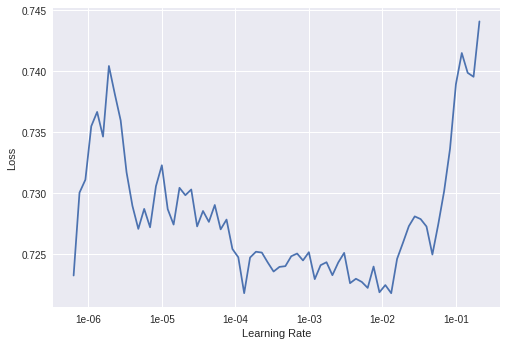

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.691735,0.697038,0.500000,16:09


### Gradual Unfreezing

In [0]:
#unfreeze last 1 layer and train
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.672092,0.671172,0.583720,17:34


In [0]:
#unfreeze last 2 layers and train
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.588279,0.546222,0.723240,24:19


In [0]:
#unfreeze whole model and train
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.487773,0.754746,0.625760,29:50
2,0.407351,0.370769,0.832560,29:59


## Prediction

In [0]:
learn.predict("Five medical students (Kevin Bacon, David Labraccio; William Baldwin, Dr. Joe Hurley; Oliver Platt, Randy Steckle; Julia Roberts, Dr. Rachel Mannus; Kiefer Sutherland, Nelson) experiment with clandestine near death & afterlife experiences, (re)searching for medical & personal enlightenment. One by one, each medical student's heart is stopped, then revived.<br /><br />Under temporary death spells each experiences bizarre visions, including forgotten childhood memories. Their flashbacks are like children's nightmares. The revived students are disturbed by remembering regretful acts they had committed or had done against them. As they experience afterlife, they bring real life experiences back into the present. As they continue to experiment, their remembrances dramatically intensify; so much so, some are physically overcome. Thus, they probe & transcend deeper into the death-afterlife experiences attempting to find a cure.<br /><br />Even though the DVD was released in 2007, this motion picture was released in 1990. Therefore, Kevin Bacon, William Baldwin, Julia Roberts & Kiefer Sutherland were in the early stages of their adult acting careers. Besides the plot being extremely intriguing, the suspense building to a dramatic climax & the script being tight & convincing, all of the young actors make \"Flatliners,\" what is now an all-star cult semi-sci-fi suspense. Who knew 17 years ago that the film careers of this young group of actors would skyrocket? I suspect that director Joel Schumacher did.")


(<fastai.core.Category at 0x7f869b99b588>, tensor(1), tensor([0.4656, 0.5344]))

In [0]:
learn.predict("This has to be one of the biggest misfires ever...the script was nice and could have ended a lot better.the actors should have played better and maybe then i would have given this movie a slightly better grade. maybe Hollywood should remake this movie with some little better actors and better director.sorry guys for disappointment but the movie is bad.<br /><br />If i had to re-watch it it would be like torture. I don't want to spoil everyone's opinion with mine so..my advice is watch the movie first..see if u like it and after vote(do not vote before you watch it ! ) and by the way... Have fun watching it ! Don't just peek...watch it 'till the end :))))))))) !!")


(<fastai.core.Category at 0x7f869b996908>, tensor(0), tensor([0.9640, 0.0360]))

In [0]:
learn.predict("A very accurate depiction of small time mob life filmed in New Jersey. The story, characters and script are believable but the acting drops the ball. Still, it's worth watching, especially for the strong images, some still with me even though I first viewed this 25 years ago.<br /><br />A young hood steps up and starts doing bigger things (tries to) but these things keep going wrong, leading the local boss to suspect that his end is being skimmed off, not a good place to be if you enjoy your health, or life.<br /><br />This is the film that introduced Joe Pesce to Martin Scorsese. Also present is that perennial screen wise guy, Frank Vincent. Strong on characterizations and visuals. Sound muddled and much of the acting is amateurish, but a great story.")


(<fastai.core.Category at 0x7f869b9932b0>, tensor(1), tensor([0.0347, 0.9653]))